# Convolutional Neural Network - Gap / Char Classification
Using TensorFlow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)

# Creating CSV
import glob
import csv

# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.datahelpers import loadGapData

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


## Load Images and Lables in CSV

In [2]:
images, labels = loadGapData('data/gapdet/large/')

Loading gap data...
-> Number of gaps and letters: 13591


In [3]:
print("Number of images: " + str(len(images)))

# Splitting on train and test data
div = int(0.90 * len(images))

trainData = images[0:div]
trainLabels = labels[0:div]

evalData = images[div:]
evalLabels = labels[div:]

print("Training images: %g" % div)

Number of images: 13591
Training images: 12231


# Create classifier

### Dataset

In [4]:
# Prepare training dataset
trainSet = DataSet(trainData, trainLabels)
evalSet = DataSet(evalData, evalLabels)

## Convulation Neural Network

### Graph

In [5]:
sess = tf.InteractiveSession()

# Help functions for standard layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# Regularization scale - FOR TWEAKING
SCALE = 0.001
# Weighting cross entropy
POS_WEIGHT = (len(labels) - sum(labels)) / sum(labels)

# Place holders for data (x) and labels (y_)
x = tf.placeholder(tf.float32, [None, 7200], name='x')
targets = tf.placeholder(tf.int64, [None])

# Reshape input data
reshape_images = tf.reshape(x, [-1, 60, 120, 1])

# Image standardization
x_images = tf.map_fn(
    lambda img: tf.image.per_image_standardization(img), reshape_images)

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.get_variable('W_conv1', shape=[8, 8, 1, 10],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[10]), name='b_conv1')

h_conv1 = tf.nn.relu(conv2d(x_images, W_conv1) + b_conv1, name='h_conv1')

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 10, 20],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[20]), name='b_conv2')

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2, name='h_pool2')

# 5. Fully Connected layer
W_fc1 = tf.get_variable('W_fc1', shape=[15*30*20, 1000],
                        initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1000]), name='b_fc1')

h_conv2_flat = tf.reshape(h_pool2, [-1, 15*30*20], name='h_conv2_flat')
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1, name='h_fc1')

# 6. Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='h_fc1_drop')

# 7. Output layer
W_fc2 = tf.get_variable('W_fc2', shape=[1000, 2],
                        initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]), name='b_fc2')

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# Activation function for real use in application
activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1, name='activation')


# Cost: cross entropy + regularization
# Regularization with L2 Regularization with decaying learning rate
# cross_entropy = tf.nn.weighted_cross_entropy_with_logits(logits=y_conv, targets=y_)
weights = tf.multiply(targets, POS_WEIGHT) + 1
cross_entropy = tf.losses.sparse_softmax_cross_entropy(
    logits=y_conv,
    labels=targets,
    weights=weights)

# Using cross entropy for sigmoid as loss
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.reduce_mean(cross_entropy) + sum(regularization)


# Optimizer
train_step = tf.train.AdamOptimizer(5e-5).minimize(cost, name='train_step')


# Evaluating
correct_prediction = tf.equal(tf.argmax(y_conv,1), targets)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

### Training

<IPython.core.display.Javascript object>


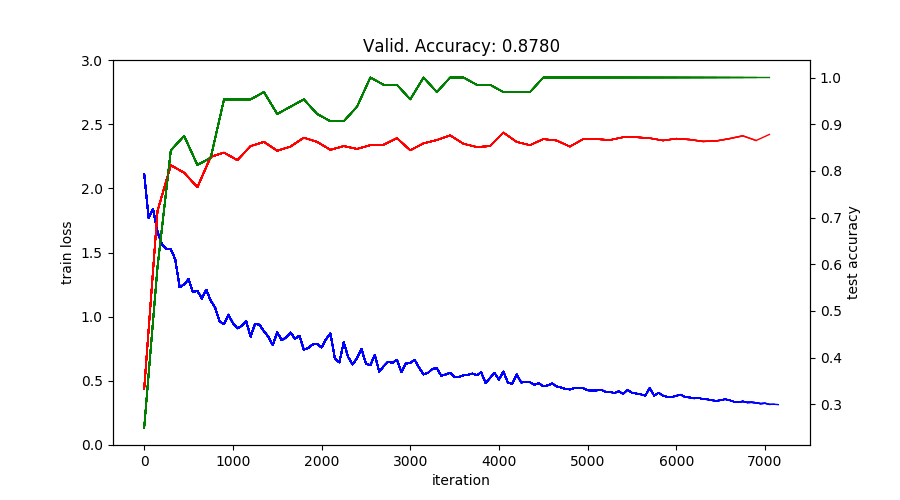

Accuracy 0.86


In [6]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### SETTINGS  ###
TRAIN_STEPS = 500000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64

# Graph for live ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

try:
    for i in range(TRAIN_STEPS):
        trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)

        if i%COST_ITER == 0:
            # Plotting cost
            tmpCost = cost.eval(feed_dict={x: trainBatch,
                                           targets: labelBatch,
                                           keep_prob: 1.0})
            trainPlot.updateCost(tmpCost, i // COST_ITER)

        if i%TEST_ITER == 0:
            # Plotting accuracy
            evalD, evalL = evalSet.next_batch(1000)
            accEval = accuracy.eval(feed_dict={x: evalD,
                                               targets: evalL,
                                               keep_prob: 1.0})
            accTrain = accuracy.eval(feed_dict={x: trainBatch,
                                                targets: labelBatch,
                                                keep_prob: 1.0})
            trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)

        if i%SAVE_ITER == 0:
            # Saving model
            saver.save(sess, 'models/gap-clas/large/CNN-CG')

        train_step.run(feed_dict={x: trainBatch,
                                  targets: labelBatch,
                                  keep_prob: 0.4})
except KeyboardInterrupt:
    pass

saver.save(sess, 'models/gap-clas/large/CNN-CG')
evalD, evalL = evalSet.next_batch(1000)
print("Accuracy %g" % accuracy.eval(feed_dict={x: evalD,
                                               targets: evalL,
                                               keep_prob: 1.0}))
sess.close()